# ADNE - Task 3

- André Bastos, nº 56969
- Rafaela Cruz, nº 56926

Tensorflow version: 2.2.0

# Imports

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from shutil import copy
import time

import IPython.display as display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Dense, Reshape
from tensorflow.keras.layers import MaxPooling2D, Activation, Flatten, Dropout, ZeroPadding2D

print(tf.__version__)

2.2.0


## Import data from Drive

In [0]:
from google.colab import drive
drive.mount('/content/google-drive')

Drive already mounted at /content/google-drive; to attempt to forcibly remount, call drive.mount("/content/google-drive", force_remount=True).


## Copying tfrecords from drive to colab

In [0]:
!mkdir trainData
copy("/content/google-drive/My Drive/ADNE/images_test.tfrecords", "./trainData/")
copy("/content/google-drive/My Drive/ADNE/images_train.tfrecords", "./trainData/")
copy("/content/google-drive/My Drive/ADNE/images_validation.tfrecords", "./trainData/")
!ls trainData

mkdir: cannot create directory ‘trainData’: File exists
images_test.tfrecords  images_train.tfrecords  images_validation.tfrecords


## Create tfrecords dataset

In [0]:
tfrecordsDir = 'trainData/'
train_raw_image_dataset = tf.data.TFRecordDataset(tfrecordsDir + 'images_train.tfrecords')
valid_raw_image_dataset = tf.data.TFRecordDataset(tfrecordsDir + 'images_validation.tfrecords')
test_raw_image_dataset = tf.data.TFRecordDataset(tfrecordsDir + 'images_test.tfrecords')

How many examples are in the tfrecord?

In [0]:
count =0
for i in train_raw_image_dataset:
    count +=1
print(count)

123922


In [0]:
count =0
for i in valid_raw_image_dataset:
    count +=1
print(count)

30981


In [0]:
count =0
for i in test_raw_image_dataset:
    count +=1
print(count)

30981


## Decode tfrecords

In [0]:
# Create a dictionary describing the features.
image_feature_description = {'label':  tf.io.FixedLenFeature([6], tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
        }

In [0]:
def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    aux = tf.io.parse_single_example(example_proto, image_feature_description)
    imageraw = aux['image_raw']
    imagemat = tf.io.decode_jpeg(imageraw, channels=3)
    imagemat = tf.cast(imagemat,dtype=tf.float32)
    imagemat = 1/255*imagemat

    label =  aux['label']
  
    #return tf.image.decode_jpeg(imageraw) #,label
    return (imagemat,label)

In [0]:
train_parsed_image_dataset = train_raw_image_dataset.map(_parse_image_function).shuffle(2000)
valid_parsed_image_dataset = valid_raw_image_dataset.map(_parse_image_function).shuffle(2000)
test_parsed_image_dataset = test_raw_image_dataset.map(_parse_image_function).shuffle(2000)

## Visualization of one example with the used model vertical strips

In [0]:
iterator = iter(train_parsed_image_dataset)
image, label = next(iterator)

print("label", label.shape)
print("image", image.shape)

label (6,)
image (48, 64, 3)


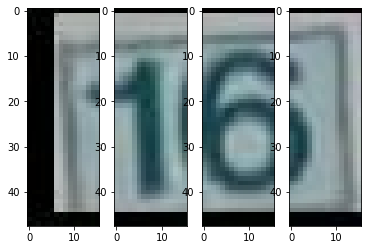

In [0]:
n = 4
splited_image = tf.split(image, n, axis = 1, num = None, name = "split")
for i,im in enumerate(splited_image):
    plt.subplot(1, n, i+1)
    plt.imshow(im, interpolation="nearest")
plt.show()

In [0]:
# Function that receives a tensor (results of 2D convolution) and n (number of slices), and cuts the image input 
# into several vertical strips, reshapping them in the end to position the batch size in first dimension
def split_tensor(t,n):
    return tf.transpose( tf.split(t, n, axis=2, num=None, name='split'), perm=[1,0,2,3,4] )

# Create Network

## Encoder

This encoder consists of a convolutional neural network that extracts features from the given input images and resizes them into a lower representation.

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, shape = (48, 64, 3)):
        super(Encoder, self).__init__()

        self.conv_1 = Conv2D(16, (5,5), strides=1, padding="same", input_shape=shape, activation='tanh')
        self.max_pool_1 = MaxPooling2D(pool_size=(2,2), strides=2)
        self.batch_norm_1 = BatchNormalization(axis=-1)
        self.drop_1 = Dropout(0.1)

        self.conv_2 = Conv2D(64, (5,5), strides=1, padding="same", input_shape=shape, activation='tanh')
        self.max_pool_2 = MaxPooling2D(pool_size=(3,3), strides=3)
        self.batch_norm_2 = BatchNormalization(axis=-1)
        self.drop_2 = Dropout(0.1)

    def call(self, inputs):

        output = self.conv_1(inputs)
        output = self.max_pool_1(output)
        output = self.batch_norm_1(output)
        output = self.drop_1(output)

        output = self.conv_2(output)
        output = self.max_pool_2(output)
        output = self.batch_norm_2(output)
        output = self.drop_2(output)

        return output


In [0]:
# Example of encoder module
BATCH_SIZE = 4
NR_STRIPS = 5
encoder = Encoder()
_example = next(iter(train_parsed_image_dataset.batch(BATCH_SIZE)))
input_example = _example[0]
label_example = _example[1]

sample_output = encoder(input_example)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))


Encoder output shape: (batch size, sequence length, units) (4, 8, 10, 64)


## Attention Mechanism
This attention mechanism, based on the paper "Attention-Based Models for Speech Recognition", allows the model to generate a number at each time step, focusing only on the relevant information.

In [0]:
class AttentionMechanism(tf.keras.layers.Layer):
    def __init__(self, units, batch_size):
        super(AttentionMechanism, self).__init__()
        # Initialize parameter learning matrices
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(units)
        self.U = tf.keras.layers.Dense(units)
        self.F = tf.keras.layers.Conv1D(3, 3, padding="same")
        # Parameter learning output neuron
        self.final_layer = tf.keras.layers.Dense(1)
        self.prev_attention_weights = tf.zeros((batch_size, NR_STRIPS, 1)) # Dimension of encoder's output: (BATCH_SIZE,NR_STRIPS,8*2*64)

    def call(self, hidden_states, enc_output):
        # Add a dimension to the hidden_states argument
        hidden_states_with_time_axis = tf.expand_dims(hidden_states, 1)
        # Gets the previous timestep alignment 
        previous_alignment = self.F(self.prev_attention_weights)
        
        # Multiply each of the inputs to be considered with parameter learning matrices
        # Values for content-based approach
        w_hidden_states = self.W(hidden_states_with_time_axis)
        v_values = self.V(enc_output)
        # Value for location awareness extension
        u_prev_align = self.U(previous_alignment)
        # Sum the results of above calculations and final layer application
        score = self.final_layer(tf.nn.tanh(w_hidden_states + v_values + u_prev_align))

        # Softmax normalization
        attention_weights = tf.nn.softmax(score, axis=1)
        # Update the previous attention weights with the current attention weights, for next timestep usage
        self.prev_attention_weights = attention_weights
        
        # Multiply the encoder outputs by the attention weights to get the context vector
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [0]:
# Example of attention mechanism module
dec_units = 512
attention_layer = AttentionMechanism(dec_units, BATCH_SIZE)
sample_hidden = tf.zeros((BATCH_SIZE, dec_units))
sample_output_splitted = split_tensor(sample_output, NR_STRIPS) # (4, 5, 8, 2, 64)
# Reshape to (4, 5, 8 * 2 * 64)
sample_output_splitted = tf.reshape(sample_output_splitted, (BATCH_SIZE, NR_STRIPS, 8 * 2 * 64))

attention_result, attention_weights = attention_layer(sample_hidden, sample_output_splitted)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


Attention result shape: (batch size, units) (4, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (4, 5, 1)


## Decoder
This enconder generates a number at each time step, based on the encoder output and the attention weights returned by the attention mechanism.


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        # Initialize recurrent neural network used - GRU
        self.rnn = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # Final layer with the same number of units as the columns created by one hot encoding
        self.fc = tf.keras.layers.Dense(11)
        
        # Initialize the attention mechanism
        self.attention = AttentionMechanism(self.dec_units, batch_sz)

    def call(self, dec_input, hidden_states, enc_output):
        # Get context vector and attention weights from attention mechanism based on the given hidden states and encoder output
        context_vector, attention_weights = self.attention(hidden_states, enc_output)
        
        # Concatenate context vector and the previous decoder output (dec_input)
        context_vector = tf.expand_dims(context_vector,1)
        dec_input = tf.concat([context_vector, dec_input], axis=-1)
        
        # Passing the concatenated vector to the GRU
        output, state = self.rnn(dec_input)
        # Had to reshape to convenient format for network
        output = tf.reshape(output, (-1, output.shape[2]))
        # Get final digit prediction by passing the output to the last layer
        prediction = self.fc(output)
        
        return prediction, state, attention_weights

In [0]:
# Example of decoder module
decoder = Decoder(10, BATCH_SIZE)
x = tf.zeros((BATCH_SIZE, 1, 11))

sample_output_splitted = split_tensor(sample_output, NR_STRIPS)
# Reshape to (4, 5, 8 * 2 * 64)
sample_output_splitted = tf.reshape(sample_output_splitted, (BATCH_SIZE, NR_STRIPS, 8 * 2 * 64))

sample_decoder_output, hid_state, attention_weights = decoder(x, sample_hidden, sample_output_splitted)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (4, 11)


# Train the Network
In this section we define the above modules to be used by the network as a whole. Also define the all the functions needed. 

Then we evaluate the results.

### Define loss and accuracy objects and functions

In [0]:
# Had to force tensorflow to run in eager mode because of an error with the graph
tf.config.experimental_run_functions_eagerly(True) 
# Initialize optimizer, loss and accuracy objects to be used
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
accuracy = tf.keras.metrics.Accuracy(name="accuracy")

# Define loss function
def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

# Function that counts the data in a certain dataset
def count_data(dataset):
    count =0
    for i in dataset:
        count +=1
    return count


### Initialize variables used by training

In [0]:
# Units used by dense layers
units = 512
# Batch size
BATCH_SIZE = 64
# Number of batches
steps_per_epoch = count_data(train_parsed_image_dataset) // BATCH_SIZE
# Number of image vertical strips
NR_STRIPS = 5
# Initialize encoder
encoder = Encoder()
# Initialize decoder
decoder = Decoder(units, BATCH_SIZE)
# Initialize first iteration values for the network: hidden states and decoder input
initial_dec_hidden = tf.zeros((BATCH_SIZE, units))
initial_dec_input = tf.zeros((BATCH_SIZE, 1, 11))

### Define train step, predict and evaluate functions

In [0]:
# Function that convert a dataset object to tensor
def convert_dataset_tensor(dataset):
    input_tensor = []
    target_tensor = []
    for (i, (inputs, targ)) in enumerate(dataset):
        input_tensor.append(inputs)
        target_tensor.append(targ)
    return tf.convert_to_tensor(input_tensor), tf.convert_to_tensor(target_tensor)

In [0]:
# Define train step, with graph signature, to be used for each batch
@tf.function
def train_step(inp, targ, BATCH_SIZE, NR_STRIPS):
    loss = 0
    with tf.GradientTape() as tape:
        # Get encoder output by executing its call function
        enc_output = encoder(inp)
        # Split encoder output into several vertical strips
        enc_output_splitted = split_tensor(enc_output, NR_STRIPS)
        # Reshape image data into a vector
        enc_output_splitted = tf.reshape(enc_output_splitted, (BATCH_SIZE, NR_STRIPS, 8 * 2 * 64))

        dec_hidden = initial_dec_hidden
        dec_input = initial_dec_input

        # Teacher forcing - feeding the target as the next input
        for t in range(0, targ.shape[1]):
            # Get decoder outputs (prediction, dec_hidden, attention_weights) by executing its call function
            predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output_splitted)
            # Get one hot encoding for targets of the batch and the current timestep
            target_one_hot = tf.one_hot(targ[:, t], 11, axis=-1)
            # Accumulate training loss
            loss += loss_function(target_one_hot, predictions)
            # Reverse one hot encoding for predictions
            pred = tf.argmax(predictions,1)
            # Accumulate training accuracy
            _ = accuracy.update_state(y_true=targ[:, t], y_pred=pred)
            # Update the decoder inputs variable for the next iteration
            dec_input = tf.expand_dims(target_one_hot, 1)

    # Get final training loss by computing the average
    batch_loss = (loss / int(targ.shape[1]))
    # Get final training accuracy from keras
    batch_accuracy = accuracy.result().numpy()
    # Get all trackable variables
    variables = encoder.trainable_variables + decoder.trainable_variables
    # Compute the gradients
    gradients = tape.gradient(loss, variables)
    # Apply the gradients to the network units
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss, batch_accuracy

# Predict function receives a tensor with shape (BATCH_SIZE,48,64,3)
def predict(input_tensor):
    # Variable that aggregates all predictions
    all_preds = []
    # Get encoder output by executing its call function
    enc_output = encoder(input_tensor)
    # Split encoder output into several vertical strips
    enc_output_splitted = split_tensor(enc_output, NR_STRIPS)
    # Reshape image data into a vector
    enc_output_splitted = tf.reshape(enc_output_splitted, (BATCH_SIZE, NR_STRIPS, 8 * 2 * 64))

    dec_hidden = initial_dec_hidden
    dec_input = initial_dec_input

    # Array that will contain every prediction for the all the timesteps
    all_predictions = []

    # Without Teacher forcing - feeding the predition as the next input
    for t in range(0, 6):

        # Get decoder outputs (prediction, dec_hidden, attention_weights) by executing its call function
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output_splitted)
        # Reverse one hot encoding for predictions
        pred = tf.argmax(predictions,1)
        # Update the decoder inputs variable for the next iteration
        dec_input = tf.expand_dims(predictions, 1)
        # Append prediction to array
        all_predictions.append(pred)

    # Get tuples with all corresponding digits referring to an image
    zipped_preds = tuple(zip(all_predictions[0].numpy(), all_predictions[1].numpy(), all_predictions[2].numpy(), all_predictions[3].numpy(), all_predictions[4].numpy(), all_predictions[5].numpy()))
    # Put the predictions in the final array without nested images
    all_preds.extend(zipped_preds)
    # Array to Tensor
    all_preds = tf.convert_to_tensor(all_preds, dtype=None, dtype_hint=None, name=None)

    return all_preds

# Predict function receives a tensor with shape (BATCH_SIZE,48,64,3) with teacher forcing
# Unlike the predict function, this one is meant to receive a dataset object
def predict_with_teacher_forcing(batched_dataset):
    # Variable that aggregates all predictions
    all_preds = []
    # Iterate every batch
    for (batch, (inputs, targ)) in enumerate(batched_dataset.take(steps_per_epoch)):

        # Get encoder output by executing its call function
        enc_output = encoder(inputs)
        # Split encoder output into several vertical strips
        enc_output_splitted = split_tensor(enc_output, NR_STRIPS)
        # Reshape image data into a vector
        enc_output_splitted = tf.reshape(enc_output_splitted, (BATCH_SIZE, NR_STRIPS, 8 * 2 * 64))

        dec_hidden = initial_dec_hidden
        dec_input = initial_dec_input

        # Array that will contain every prediction for the all the timesteps
        all_predictions = []

        # Teacher forcing - feeding the target as the next input
        for t in range(0, targ.shape[1]):
            # Get decoder outputs (prediction, dec_hidden, attention_weights) by executing its call function
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output_splitted)
            # Reverse one hot encoding for predictions
            pred = tf.argmax(predictions,1)
            # Get one hot encoding for the target
            target_one_hot = tf.one_hot(targ[:, t], 11, axis=-1)
            # Update the decoder inputs variable for the next iteration
            dec_input = tf.expand_dims(target_one_hot, 1)
            # Append prediction to array
            all_predictions.append(pred)

        # Get tuples with all corresponding digits referring to an image
        zipped_preds = tuple(zip(all_predictions[0].numpy(), all_predictions[1].numpy(), all_predictions[2].numpy(), all_predictions[3].numpy(), all_predictions[4].numpy(), all_predictions[5].numpy()))
        # Put the predictions in the final array without nested images
        all_preds.extend(zipped_preds)
    # Array to Tensor - Batch format
    all_preds = tf.convert_to_tensor(all_preds, dtype=None, dtype_hint=None, name=None)

    return all_preds

# Evaluate function that receives a dataset object and returns the average loss and accuracy
def evaluate(dataset, is_validation = False):
    # Get the dateset batched
    dataset_batched = dataset.batch(BATCH_SIZE, drop_remainder=True)
    # If it is a validation case for the train, use teacher forcing
    # If not, do not use teacher forcing and create batches as tensors for the predict call
    if is_validation:
        # Get predictions using teacher forcing
        predictions = predict_with_teacher_forcing(dataset_batched)
    else:
        # Get input and labels tensors
        dataset_input, dataset_target = convert_dataset_tensor(dataset)
        # Iterate through the dataset
        iterator = iter(dataset.batch(BATCH_SIZE))
        # Get first image and label
        image, label = next(iterator)
        size_dataset = count_data(dataset)
        # Get limit for while
        limit = size_dataset // BATCH_SIZE
        # Array that will contain predictions as batches
        all_preds = []
        count = 0
        while (count < limit):
            count += 1
            # Get prediction
            predictions = predict(image)
            all_preds.append(predictions)
            image, label = next(iterator)

        # Convert the array to a tensor
        predictions = tf.convert_to_tensor(all_preds)

    # Variables to loss and accuracy calculation
    total_loss = 0
    total_accuracy = 0
    # Reset accuracy object states
    accuracy.reset_states()
    count = 0
    # Try is in case an exception is raised due to the remaining images not batched, when it is not a validation case
    try:
        dataset_it = dataset_batched
        # If is a validation case then there use the whole dataset and not the batched one
        if is_validation : dataset_it = dataset
        for (i, (inputs, targ)) in enumerate(dataset_it):
            count += 1
            total_loss += loss_function(tf.one_hot(targ, 11, axis=-1), tf.one_hot(predictions[i], 11, axis=-1))
            _ = accuracy.update_state(y_true=targ, y_pred=predictions[i])
    except:
        total_loss = total_loss / count
        total_accuracy = accuracy.result()
        return total_loss.numpy(), total_accuracy.numpy()

    # Compute the average for the loss and accuracy
    total_loss = total_loss / count
    total_accuracy = accuracy.result()
    return total_loss.numpy(), total_accuracy.numpy()


### Training Loop

In [0]:
# Number of epochs
EPOCHS = 6
# Get a batched dataset
train_parsed_image_dataset_batched = train_parsed_image_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Initialize arrays for losses and accuracy values, both for training and validation
all_losses_train = []
all_accuracy_train = []
all_losses_val = []
all_accuracy_val = []

# Iterate for the epochs
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    total_accuracy = 0
    # Reset accuracy object states
    accuracy.reset_states()
    train_parsed_image_dataset_took = train_parsed_image_dataset_batched.take(steps_per_epoch)
    # Iterate the batches
    for (batch, (inp, targ)) in enumerate(train_parsed_image_dataset_took):
        # Apply a training step for the batch
        batch_loss, batch_accuracy = train_step(inp, targ, BATCH_SIZE, NR_STRIPS)
        total_loss += batch_loss
        total_accuracy += batch_accuracy

        # Sometimes print results
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, batch_loss.numpy(), batch_accuracy))

    # Get the validation loss and accuracy by calling the evaluate function
    val_loss, val_accuracy = evaluate(valid_parsed_image_dataset, is_validation = True)
    # Append validation values
    all_losses_val.append(val_loss)
    all_accuracy_val.append(val_accuracy)

    # Append training values
    all_losses_train.append(total_loss.numpy() / steps_per_epoch)
    all_accuracy_train.append(total_accuracy / steps_per_epoch)

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch, total_accuracy / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    print("all_losses_val", all_losses_val)
    print("all_accuracy_val", all_accuracy_val)
    print("all_losses_train", all_losses_train)
    print("all_accuracy_train", all_accuracy_train)


Epoch 1 Batch 0 Loss 2.4002 Accuracy 0.0599
Epoch 1 Batch 100 Loss 1.3357 Accuracy 0.5667
Epoch 1 Batch 200 Loss 1.0830 Accuracy 0.5914
Epoch 1 Batch 300 Loss 1.0376 Accuracy 0.6039
Epoch 1 Batch 400 Loss 1.0272 Accuracy 0.6115
Epoch 1 Batch 500 Loss 1.0062 Accuracy 0.6179
Epoch 1 Batch 600 Loss 0.9860 Accuracy 0.6236
Epoch 1 Batch 700 Loss 0.9260 Accuracy 0.6300
Epoch 1 Batch 800 Loss 0.9321 Accuracy 0.6370
Epoch 1 Batch 900 Loss 0.8800 Accuracy 0.6442
Epoch 1 Batch 1000 Loss 0.7776 Accuracy 0.6542
Epoch 1 Batch 1100 Loss 0.7228 Accuracy 0.6647
Epoch 1 Batch 1200 Loss 0.6038 Accuracy 0.6755
Epoch 1 Batch 1300 Loss 0.6717 Accuracy 0.6856
Epoch 1 Batch 1400 Loss 0.5524 Accuracy 0.6957
Epoch 1 Batch 1500 Loss 0.4203 Accuracy 0.7050
Epoch 1 Batch 1600 Loss 0.5065 Accuracy 0.7140
Epoch 1 Batch 1700 Loss 0.4455 Accuracy 0.7225
Epoch 1 Batch 1800 Loss 0.4244 Accuracy 0.7304
Epoch 1 Batch 1900 Loss 0.3667 Accuracy 0.7381
Epoch 1 Loss 0.8068 Accuracy 0.6542
Time taken for 1 epoch 487.129216432

## Results

### Plot loss and accuracy

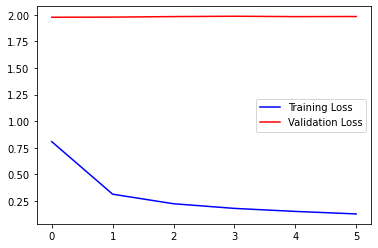

In [0]:
f, ax = plt.subplots(1)
ax.plot(all_losses_train,'b',label='Training Loss')
ax.plot(all_losses_val,'r',label='Validation Loss')
ax.legend()
plt.show(f)

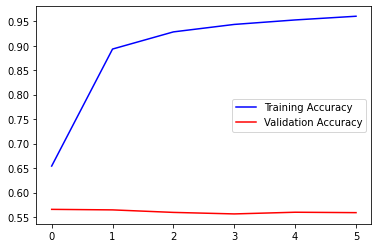

In [0]:
f, ax = plt.subplots(1)
ax.plot(all_accuracy_train,'b',label='Training Accuracy')
ax.plot(all_accuracy_val,'r',label='Validation Accuracy')
ax.legend()
plt.show(f)

## Test Network



In [0]:
evaluate(test_parsed_image_dataset)

(2.3246653, 0.21837874)